In [1]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [2]:
from toolz import compose
import pyspark.sql
from pyspark.sql.functions import (
    expr,
    col,
    to_timestamp,
    format_string,
    regexp_extract,
    datediff,
    current_timestamp,
    when,
    max,
    lit,
)


def get_311_data(spark: pyspark.sql.SparkSession) -> pyspark.sql.DataFrame:
    print("[wrangle.py] reading case.csv")
    df = spark.read.csv("data/case.csv", header=True, inferSchema=True)
    return df.withColumnRenamed("SLA_due_date", "case_due_date")


def handle_dtypes(df: pyspark.sql.DataFrame) -> pyspark.sql.DataFrame:
    print("[wrangle.py] handling data types")
    return (
        df.withColumn("case_closed", expr('case_closed == "YES"'))
        .withColumn("case_late", expr('case_late == "YES"'))
        .withColumn("council_district", col("council_district").cast("string"))
    )


def handle_dates(df: pyspark.sql.DataFrame) -> pyspark.sql.DataFrame:
    print("[wrangle.py] parsing dates")
    fmt = "M/d/yy H:mm"
    return (
        df.withColumn("case_opened_date", to_timestamp("case_opened_date", fmt))
        .withColumn("case_closed_date", to_timestamp("case_closed_date", fmt))
        .withColumn("case_due_date", to_timestamp("case_due_date", fmt))
    )

def wrangle_311(spark: pyspark.sql.SparkSession) -> pyspark.sql.DataFrame:
    df = add_features(handle_dates(handle_dtypes(get_311_data(spark))))
    return join_departments(df, spark)

def add_features(df: pyspark.sql.DataFrame) -> pyspark.sql.DataFrame:
    print("[wrangle.py] adding features")
    max_date = df.select(max("case_closed_date")).first()[0]
    return (
        df.withColumn("num_weeks_late", expr("num_days_late / 7 AS num_weeks_late"))
        .withColumn(
            "council_district",
            format_string("%03d", col("council_district").cast("int")),
        )
        .withColumn("zipcode", regexp_extract("request_address", r"\d+$", 0))
        .withColumn("case_age", datediff(lit(max_date), "case_opened_date"))
        .withColumn("days_to_closed", datediff("case_closed_date", "case_opened_date"))
        .withColumn(
            "case_lifetime",
            when(expr("! case_closed"), col("case_age")).otherwise(
                col("days_to_closed")
            ),
        )
    )

def join_departments(
    case_df: pyspark.sql.DataFrame, spark: pyspark.sql.SparkSession
) -> pyspark.sql.DataFrame:
    print("[wrangle.py] joining departments")
    dept = spark.read.csv("data/dept.csv", header=True, inferSchema=True)
    return (
        case_df.join(dept, "dept_division", "left")
        # drop all the columns except for standardized name, as it has much fewer unique values
        .drop(dept.dept_division)
        .drop(dept.dept_name)
        .drop(case_df.dept_division)
        .withColumnRenamed("standardized_dept_name", "department")
        # convert to a boolean
        .withColumn("dept_subject_to_SLA", col("dept_subject_to_SLA") == "YES")
    )

In [3]:
df = wrangle_311(spark)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments


In [4]:
df.printSchema()

root
 |-- case_id: integer (nullable = true)
 |-- case_opened_date: timestamp (nullable = true)
 |-- case_closed_date: timestamp (nullable = true)
 |-- case_due_date: timestamp (nullable = true)
 |-- case_late: boolean (nullable = true)
 |-- num_days_late: double (nullable = true)
 |-- case_closed: boolean (nullable = true)
 |-- service_request_type: string (nullable = true)
 |-- SLA_days: double (nullable = true)
 |-- case_status: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- request_address: string (nullable = true)
 |-- council_district: string (nullable = false)
 |-- num_weeks_late: double (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- case_age: integer (nullable = true)
 |-- days_to_closed: integer (nullable = true)
 |-- case_lifetime: integer (nullable = true)
 |-- department: string (nullable = true)
 |-- dept_subject_to_SLA: boolean (nullable = true)



# 1. How many different cases are there, by department?


In [5]:
df.groupby("department").count().show()


+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



Text(0.5, 0, 'Number of Cases')

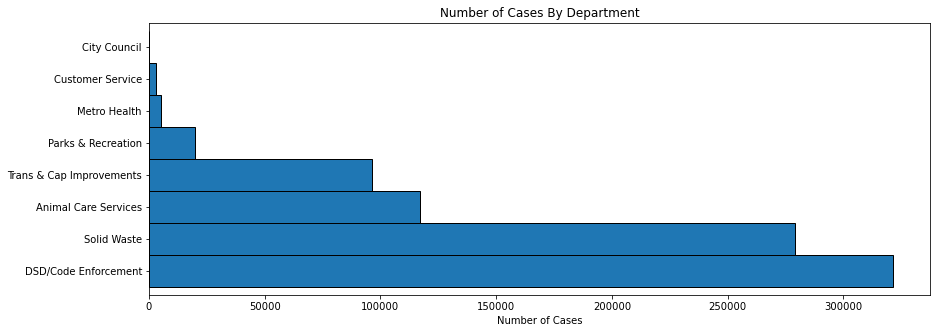

In [6]:
(
    df.groupBy("department")
    .count()
    # then pass to pandas
    .toPandas()
    .set_index("department")["count"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.title("Number of Cases By Department")
plt.ylabel("")
plt.xlabel("Number of Cases")

In [7]:
df.groupBy("department").count().toPandas()

,department,count
0,Solid Waste,279270
1,Animal Care Services,116915
2,Trans & Cap Improvements,96193
3,Parks & Recreation,19907
4,Customer Service,2849
5,Metro Health,5163
6,City Council,33
7,DSD/Code Enforcement,321374


In [8]:
sample = df.sample(fraction=0.01, seed=13).toPandas()
print("shape:", sample.shape)
sample.head()

shape: (8441, 20)


,case_id,case_opened_date,case_closed_date,case_due_date,case_late,num_days_late,case_closed,service_request_type,SLA_days,case_status,source_id,request_address,council_district,num_weeks_late,zipcode,case_age,days_to_closed,case_lifetime,department,dept_subject_to_SLA
0,1014127339,2018-01-01 06:58:00,2018-01-02 15:32:00,2018-01-17 08:30:00,False,-14.706620,True,Front Or Side Yard Parking,16.063796,Closed,svcCRMSS,"10133 FIGARO CANYON, San Antonio, 78251",004,-2.100946,78251,219,1.0,1,DSD/Code Enforcement,True
1,1014127368,2018-01-01 07:18:00,2018-01-02 15:22:00,2018-01-17 08:30:00,False,-14.713275,True,Right Of Way/Sidewalk Obstruction,16.049769,Closed,svcCRMSS,"10133 FIGARO CANYON, San Antonio, 78251",004,-2.101896,78251,219,1.0,1,DSD/Code Enforcement,True
2,1014127446,2018-01-01 11:27:00,2018-01-03 17:08:00,2018-01-06 11:27:00,False,-2.763333,True,Aggressive Animal(Non-Critical),5.000000,Closed,139344,SAN FERNANDO and SAN HORACIO S,005,-0.394762,,219,2.0,2,Animal Care Services,True
3,1014127470,2018-01-01 12:33:00,2018-01-01 12:43:00,2020-09-26 12:33:00,False,-998.993079,True,Stray Animal,999.000000,Closed,139344,"159 SURFRIDER, San Antonio, 78242",004,-142.713297,78242,219,0.0,0,Animal Care Services,True
4,1014127599,2018-01-01 15:25:00,2018-01-03 05:52:00,2018-01-02 03:25:00,True,1.101817,True,Trapped/Confined Animal,0.500000,Closed,rs16746,"633 ST MARYS S, San Antonio, 78205",001,0.157402,78205,219,2.0,2,Animal Care Services,True


In [11]:
sample.groupby(['department']).case_id.agg('count')

department
Animal Care Services        1118
Customer Service              32
DSD/Code Enforcement        3262
Metro Health                  63
Parks & Recreation           184
Solid Waste                 2799
Trans & Cap Improvements     983
Name: case_id, dtype: int64

# 2. Does the percentage of cases that are late vary by department?


In [20]:
sample.groupby(['department', 'case_late']).case_id.agg('count')

department                case_late
Animal Care Services      False         877
                          True          241
Customer Service          False           8
                          True           24
DSD/Code Enforcement      False        2982
                          True          280
Metro Health              False          54
                          True            9
Parks & Recreation        False         150
                          True           34
Solid Waste               False        2469
                          True          330
Trans & Cap Improvements  False         937
                          True           46
Name: case_id, dtype: int64

In [24]:
# Yes it varies substantially by department

# 3. On average, how late are the late cases by department?


In [25]:
df.show(1, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only showing top 1 row



In [27]:
df.createOrReplaceTempView('case_view')


In [30]:
spark.sql(
    """
    SELECT department, avg(num_days_late)
    FROM case_view
    Group BY department;
    
    """
).show()

+--------------------+-------------------+
|          department| avg(num_days_late)|
+--------------------+-------------------+
|         Solid Waste| -2.193864424022545|
|Animal Care Services|-226.16549770717506|
|Trans & Cap Impro...|-20.509793501785314|
|  Parks & Recreation| -5.283345998745901|
|    Customer Service|  59.49019459221518|
|        Metro Health| -4.904223205386017|
|        City Council|               null|
|DSD/Code Enforcement| -38.32346772537388|
+--------------------+-------------------+



In [31]:
sample.groupby(['department']).num_days_late.mean()

department
Animal Care Services       -222.739414
Customer Service             73.419864
DSD/Code Enforcement        -37.931820
Metro Health                 -4.818110
Parks & Recreation           -1.519446
Solid Waste                  -2.385478
Trans & Cap Improvements    -20.108770
Name: num_days_late, dtype: float64

In [35]:
df.groupby(['department'])['num_days_late'].agg('mean').toPandas()

TypeError: 'GroupedData' object is not subscriptable